In [2]:
%matplotlib inline
import numpy as np

In [3]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
from skimage.draw import polygon

## Data exploratory:

In [4]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        contour = {}
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber ##
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
    return contours

def get_mask(contours, slices):
    z = [round(s.ImagePositionPatient[2],1) for s in slices] ##
    #print(z)
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3)) #triplets describing points of contour
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            #print(np.around(nodes[0, 2], 1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num

        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors


In [5]:
train_data_path = 'C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/AAPM-RT-MAC/'

train_patients = [os.path.join(train_data_path, name) 
                    for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

In [6]:
##lettura con ordinamento cartelle

patient = train_patients[24] ##sample patient
print(patient)


for dirs, subdir, files in os.walk(patient):
    ordered_subdirs = sorted(subdir, key=lambda x: len(os.listdir(os.path.join(dirs, x))))
    ordered_subdirs = [os.path.join(dirs, subdirname) for subdirname in ordered_subdirs]
    for subdirname in ordered_subdirs:
        if any('.dcm' in elem for elem in os.listdir(subdirname)) and len(os.listdir(subdirname))==1:
            structure = dicom.read_file(os.path.join(subdirname, os.listdir(subdirname)[0]))
            contours = read_structure(structure)
        elif any('.dcm' in elem for elem in os.listdir(subdirname)) and len(os.listdir(subdirname))>1:
            dcms = [os.path.join(subdirname, dcm) for dcm in os.listdir(subdirname)]
            slices = [dicom.read_file(dcm) for dcm in dcms]
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            image = np.stack([s.pixel_array for s in slices], axis=-1)
            label, colors = get_mask(contours, slices)

C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/AAPM-RT-MAC/RTMAC-TRAIN-001


## Parotid

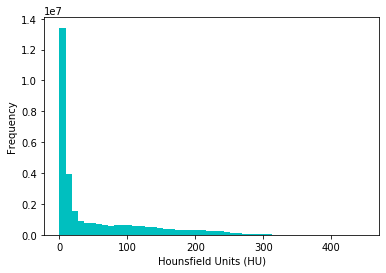

In [7]:
plt.hist(image.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

-There's an abundance of soft tissue, mostly muscle, and some fat (0 to 60) 

In [8]:
print("Slice Thickness: %f" % slices[8].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (slices[8].PixelSpacing[0], slices[8].PixelSpacing[1]))

Slice Thickness: 2.000000
Pixel Spacing (row, col): (0.500000, 0.500000) 


(-0.5, 511.5, 511.5, -0.5)

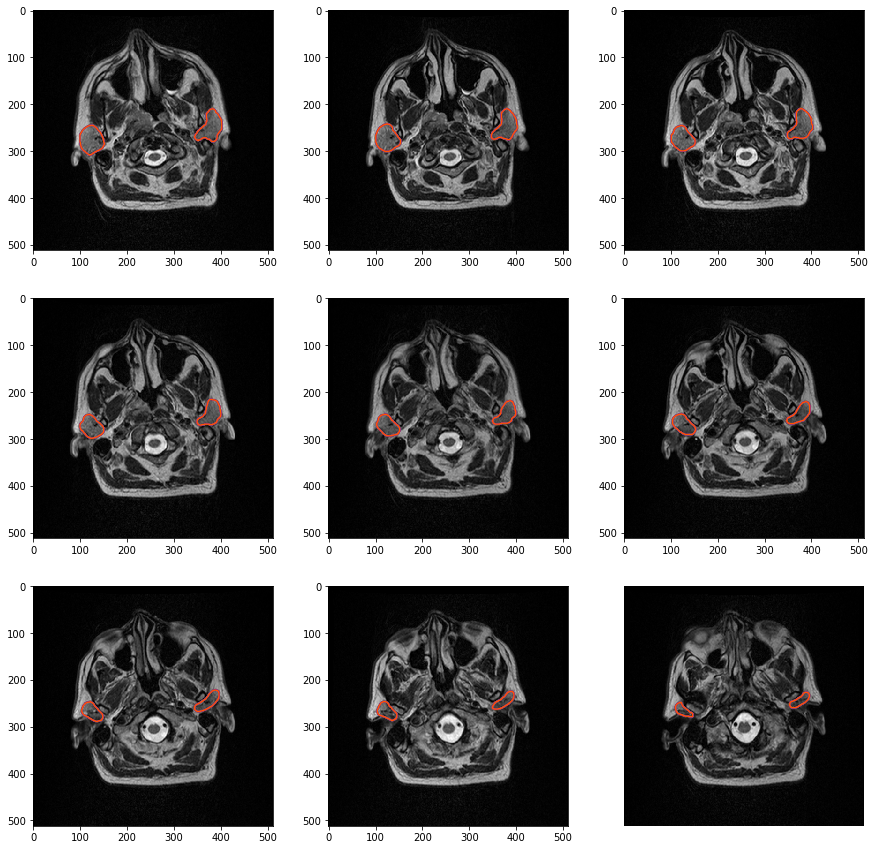

In [9]:
# Plot to check slices, for example 50 to 59

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i + 75 ], cmap="gray")
    plt.contour(label[..., i + 75 ], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.axis('off')

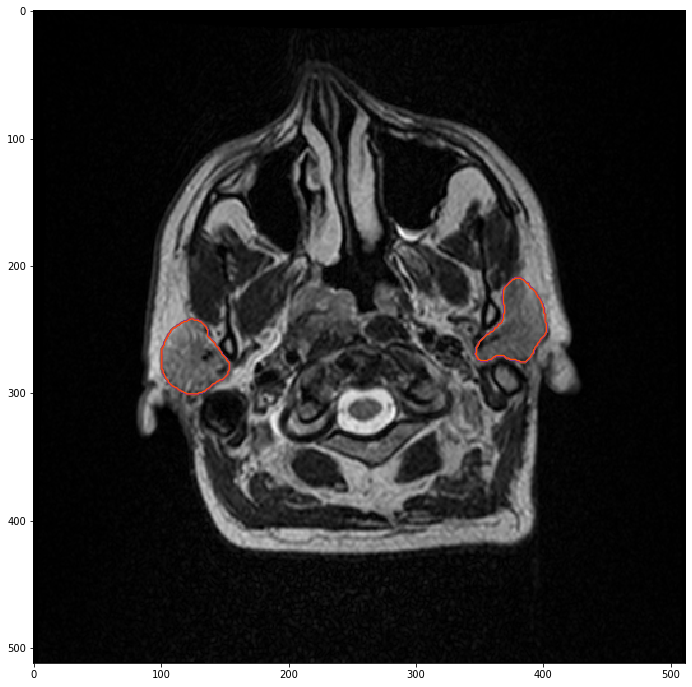

In [10]:
target_img = image[..., 76]
target_label = label[..., 76]
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(target_img, cmap="gray")
plt.contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.show()

## Finding surface voxels:

In [11]:
from scipy.stats import uniform, norm
import scipy.stats as sct
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

row_size = target_label.shape[0]
col_size = target_label.shape[1]

#for N in good_labels:
mask = np.where(target_label==7,7,0)
interior = morphology.erosion(mask,np.ones([3,3])) # one last dilation 
contour = np.where(interior==0, 1, 0)
surface = contour*mask

In [12]:
surface

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

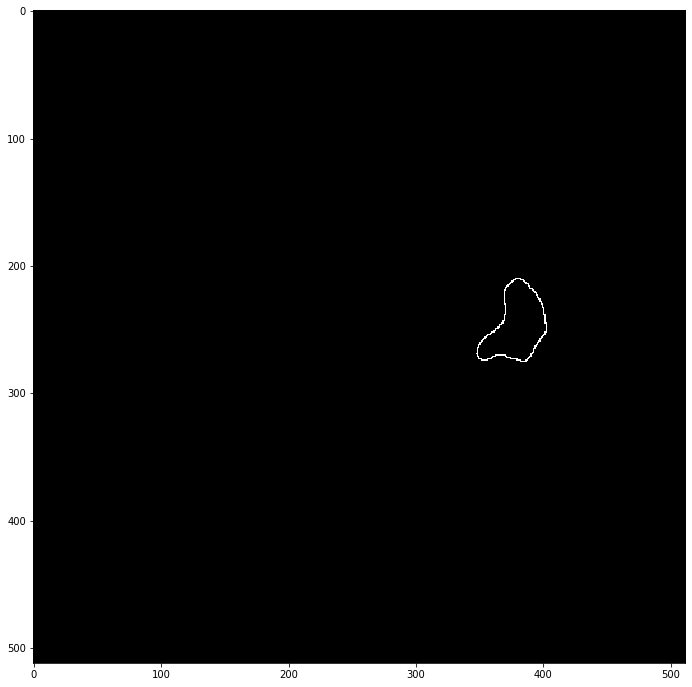

In [13]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(surface, cmap="gray")
#plt.contour(contour, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
#plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
plt.show()

## ASSD implementation

## Nearest Neighbor Search alg:

In [14]:
def search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance):
    if vector[i] != 0:   
        if i-r > 0:
            if i-r < min(pos_current_distance):
                pos_current_distance.append(i-r)
                #pos_neighbor = vector[i]
                pos_neighbor = i
            
        elif i-r < 0:
            if abs(i-r) < min(neg_current_distance):
                neg_current_distance.append(abs(i-r))
                #neg_neighbor = vector[i]
                neg_neighbor = i
    return pos_neighbor, neg_neighbor

def nearest_neighbor_search(vector, r):
    pos_neighbor = 0
    neg_neighbor = 0
    pos_current_distance = [len(vector)]
    neg_current_distance = [len(vector)]
    for i in range(0, len(vector)-1):
        pos_neighbor, neg_neighbor = search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance)
    return pos_neighbor, neg_neighbor

## ASSD Implementation

In [15]:
def find_Fsd():
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_x=norm.ppf(pRand_k, 0, SD[0])
    #pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_y=norm.ppf(pRand_k, 0, SD[1])
    #pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_z=norm.ppf(pRand_k, 0, SD[2])
    #Fsd_z=sct.norm.cdf(pRand_k, loc=0, scale=SD[2])
    Fsd_r = np.array([float(Fsd_x), float(Fsd_y), float(Fsd_z)])
    return Fsd_r

def find_Fct(roi, r, i, a, voxelsize):
    gradct = (roi[r+1,i]-roi[r-1, i])/(2*voxelsize)
    gradct_x = gradct[0]
    gradct_y = gradct[1]
    gradct_z = gradct[2]
    Fct_x = a/(np.abs(gradct_x)+a)
    Fct_y = a/(np.abs(gradct_y)+a)
    Fct_z = a/(np.abs(gradct_z)+a)
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r
        
def find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize):
    Fct_x = neg_Fct_r[0] + (pos_Fct_r[0] - neg_Fct_r[0])/((pos_r - neg_r)*voxelsize[0])*((r - neg_r)*voxelsize[0])
    Fct_y = neg_Fct_r[1] + (pos_Fct_r[1] - neg_Fct_r[1])/((pos_r - neg_r)*voxelsize[1])*((r - neg_r)*voxelsize[1])
    Fct_z = neg_Fct_r[2] + (pos_Fct_r[2] - neg_Fct_r[2])/((pos_r - neg_r)*voxelsize[2])*((r - neg_r)*voxelsize[2])
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r

def find_D(Fsd_r, Fct_r):
    Fct_x =  Fct_r[0]
    Fct_y =  Fct_r[1]
    Fct_z =  Fct_r[2]
    Fsd_x =  Fsd_r[0]
    Fsd_y =  Fsd_r[1]
    Fsd_z =  Fsd_r[2]
    D_x = (Fsd_x*Fct_x)
    D_y = Fsd_y*Fct_y
    D_z = Fsd_z*Fct_z
    D_r = [float(D_x), float(D_y), float(D_z)]
    return D_r

def r_to_xyz(F):
    F_x =  F[0]
    F_y =  F[1]
    F_z =  F[2]
    return F_x, F_y, F_z

In [16]:
def assd(slices, contour, k, voxelsize, a, SD, surface, interior):
    roi=slices*contour
    dim=roi.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    dx = np.zeros((512, 512))
    dy = np.zeros((512, 512))
    D = []
    for i in range(0,dim-1):
        for r in range(0,dim-1): 
            if roi[r, i] != 0 and surface[r, i] != 0:
                Fsd_r = find_Fsd()
                Fct_r = find_Fct(roi, r, i, a, voxelsize)
                D_r = find_D(Fsd_r, Fct_r)
                D_x, D_y, D_z = r_to_xyz(D_r)
                dx[r, i] = D_x
                dy[r, i] = D_y
                D.append(D_r)
                roi[r, i] = 1
            
            elif roi[r, i] != 0 and interior[r, i] != 0:
                pos_r, neg_r = nearest_neighbor_search(surface[r], i)
                if pos_r > neg_r:
                    Fsd_r =  find_Fsd()
                    pos_Fct_r = find_Fct(roi, pos_r, i, a, voxelsize)
                    neg_Fct_r = find_Fct(roi, neg_r, i, a, voxelsize)
                    pos_Fct_x, pos_Fct_y, pos_Fct_z = r_to_xyz(pos_Fct_r)
                    neg_Fct_x, neg_Fct_y, neg_Fct_z = r_to_xyz(neg_Fct_r)
                    Fct_r = find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize)
                    D_r = find_D(Fsd_r, Fct_r)
                    D_x, D_y, D_z = r_to_xyz(D_r)
                    dx[r, i] = D_x
                    dy[r, i] = D_y
                    D.append(D_r)
                    roi[r, i] = 0
            
    return D, dx, dx, roi

In [174]:
#roi = target_label*target_img
k=1
a=50
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.5, 0.5, 2])
SD=[2, 2.5, 3]
assd_mask, dx, dy, roi_new = assd(target_img, mask, k, voxelsize, a, SD, surface, interior)

## Ploting the vector field of gradient D:

In [175]:
a = np.zeros([512, 512])
roi_cord = np.argwhere(mask != 0)
x = []
y = []
for i in roi_cord.tolist():
    x.append(i[0])
    y.append(i[1])
x = np.array(x)
y = np.array(y)
a[x, y] = 1

In [176]:
len(x)

2166

In [177]:
u = []
v = []
u_cord = np.argwhere(dx != 0)
v_cord = np.argwhere(dy != 0)

for i in u_cord.tolist():
    u.append(dx[i[0], i[1]])
for i in v_cord.tolist():
    v.append(dy[i[0], i[1]])
u = np.array(u)
v = np.array(v)

In [178]:
len(u)

2166

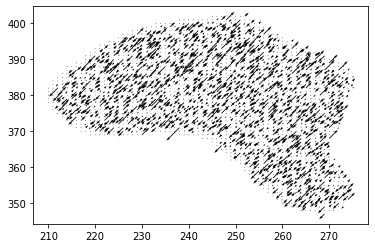

In [179]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots()
#plt.scatter(x, y, color='r', s=1)
ax.quiver(x, y, v, u)
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             #label='Quiver key, length = 10', labelpos='E')

plt.show()

In [180]:
import math
DU_mask = np.zeros((512,512))
x_new = x + v
y_new = y + u
for i in range(len(x_new)-1):
    DU_mask[int(round(x_new[i], 0)), int(round(y_new[i], 0))] = 1
    DU_mask[int(x[i]), int(y[i])] = 1

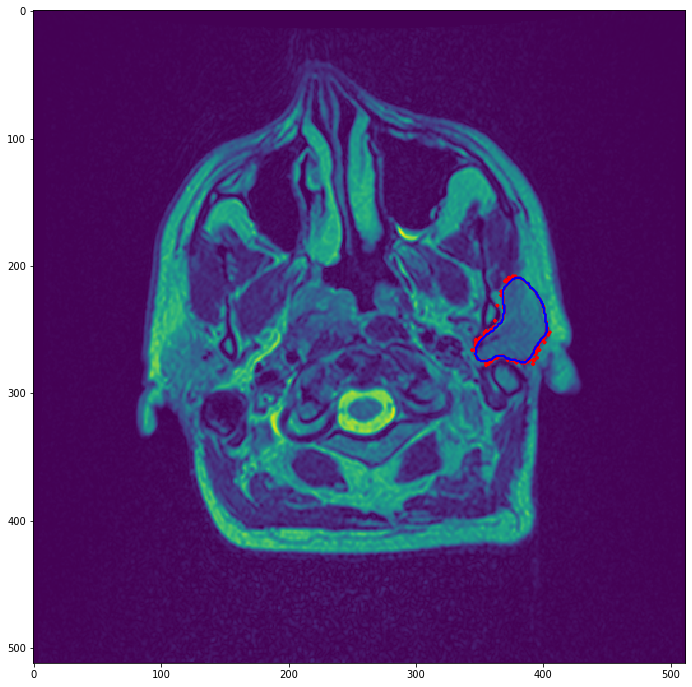

In [181]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
#ax.quiver(x, y, u, v)
#ax.scatter(x_new, y_new, color="r", s=2)
ax.contour(DU_mask, colors="red")
ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             #label='Quiver key, length = 10', labelpos='E')
plt.show()

## Smooth contouring methods:

## Threshold, Erosion and Dilaton

In [192]:
#Standardize the pixel values
def make_mask(img, display=False):
    threshold = np.mean(img)
    print(threshold)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([8,8]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        #if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
        good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(2, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Smoothing noise using Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Mask")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        
        plt.show()
    return labels

0.00861358642578125


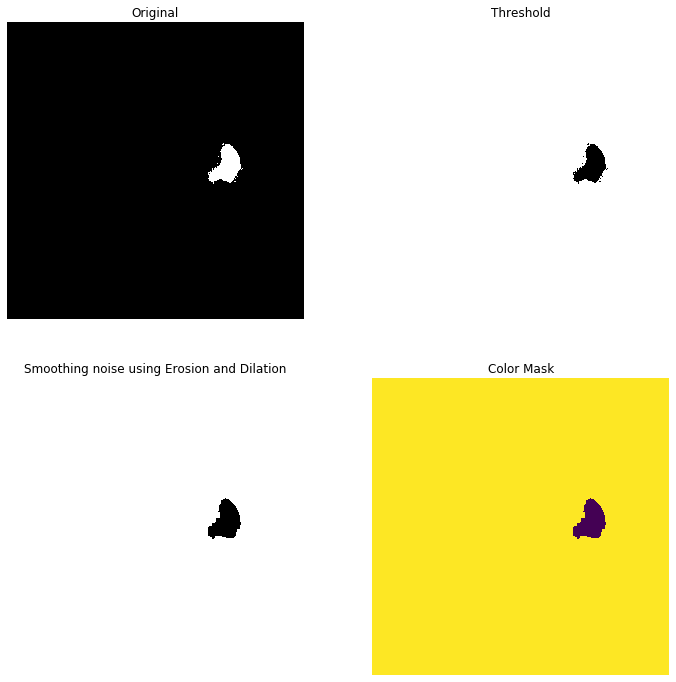

In [193]:
du = make_mask(DU_mask, display=True)

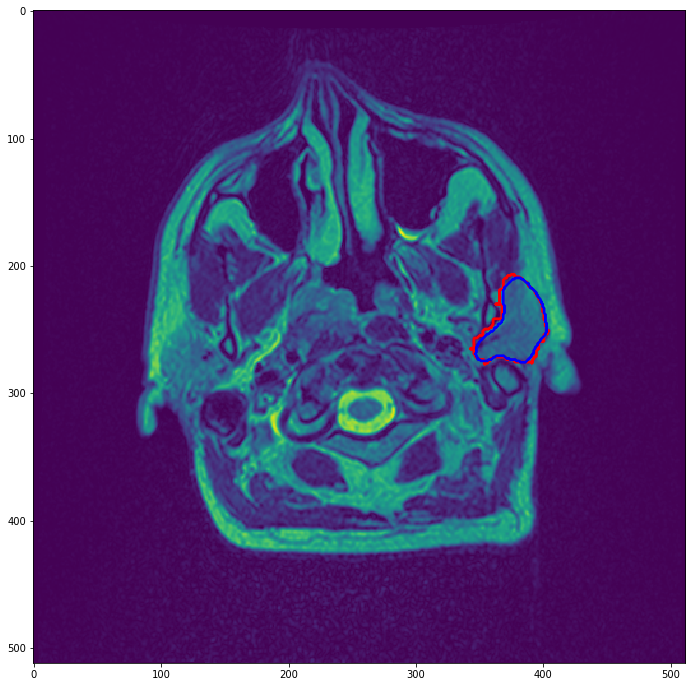

In [196]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
#ax.contour(DU_mask)
ax.contour(du, colors="red")
ax.contour(mask, colors="blue")
plt.show()

## Gaussian KDE

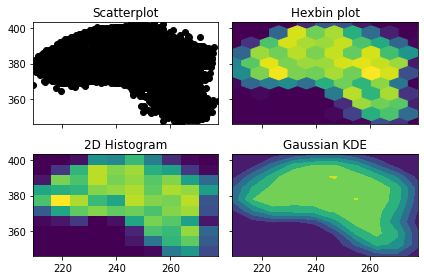

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

np.random.seed(1977)

# Generate 200 correlated x,y points
#data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
x, y = x_new, y_new

nbins = 10

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

axes[0, 0].set_title('Scatterplot')
axes[0, 0].plot(x, y, 'ko')

axes[0, 1].set_title('Hexbin plot')
axes[0, 1].hexbin(x, y, gridsize=nbins)

axes[1, 0].set_title('2D Histogram')
axes[1, 0].hist2d(x, y, bins=nbins)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(np.array([x_new, y_new]))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axes[1, 1].set_title('Gaussian KDE')
axes[1, 1].contourf(xi, yi, zi.reshape(xi.shape))

fig.tight_layout()
plt.show()

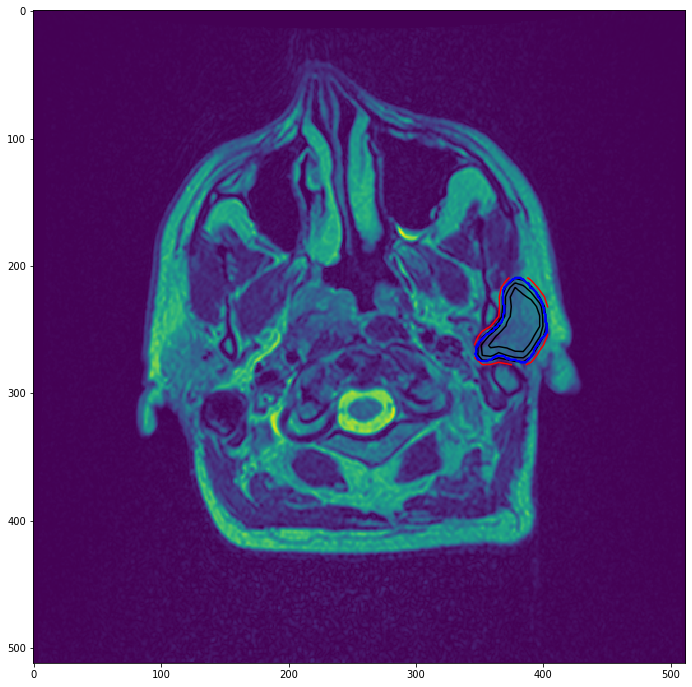

In [67]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
#ax.scatter(y_new, x_new, color="r", s=2)
ax.contour(yi, xi, zi.reshape(xi.shape), levels=4, colors=('black', 'red', 'black', 'black'))
ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")

plt.show()